<a href="https://colab.research.google.com/github/Af4rinz/CV-Codelets/blob/main/Cube_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Mapping to a Cube Using Affine Transforms


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib.pyplot import imshow

Open image using pyplot:

In [2]:
def loadImage(name):
  image = plt.imread('/content/drive/MyDrive/ComputerVision/CV-Phase1/' + name)
  print(image.shape)
  print(type(image))
  return image

In [3]:
girl_img = loadImage('girl.bmp')

(512, 512, 3)
<class 'numpy.ndarray'>


The Numpy array's shape is 512×512×3, the last dimension giving the three bands of the image. We can use them individually to view the single band versions in each channel (here channels use greyscale mapping, but can easily be changed using pyplot's various colourmaps).

In [4]:
# set colour map to greyscale 
# for upcoming pyplot figures
plt.gray() 

<Figure size 432x288 with 0 Axes>

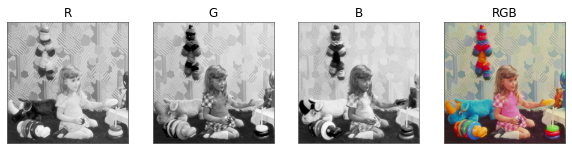

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
for idx, (ax, band) in enumerate(zip(axs, ['r', 'g', 'b'])):
    ax.imshow(girl_img[:,:,idx])
    ax.set_title(band.capitalize())
    ax.axis('off')
axs[3].imshow(girl_img)
axs[3].set_title('RGB')
axs[3].axis('off')
plt.show()

We define a function to convert an rgb (3-band) image to a single-band greyscale one. The function is based on Matlab's `greyscale` function.

In [6]:
def rgb2grey(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  grey = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return grey

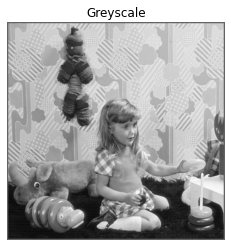

In [7]:
girl_grey = rgb2grey(girl_img)
plt.axis("off")
plt.title("Greyscale")
plt.imshow(girl_grey)

Opening and reviewing the other two images quickly:

(512, 512, 3)
<class 'numpy.ndarray'>
(512, 512, 3)
<class 'numpy.ndarray'>


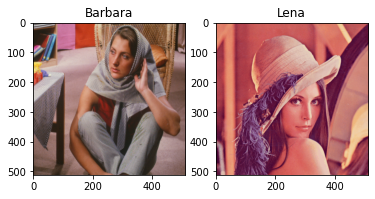

In [8]:
barb_img = loadImage('barbara.bmp')
lena_img = loadImage('lena.bmp')
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(barb_img)
axs[0].set_title('Barbara')
axs[1].imshow(lena_img)
axs[1].set_title('Lena')
plt.show()

## Transformation Matrix

(956, 964, 3)
<class 'numpy.ndarray'>


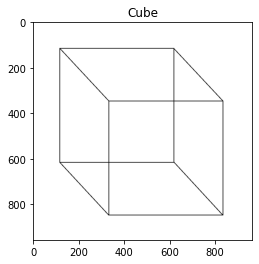

In [9]:
cube = loadImage('Cube.png')
# loaded as [0..1] float
# change to [0..255] int
cube = (cube*255).astype(np.uint8)
plt.title('Cube')
plt.imshow(cube)

This implementation uses backward transformation, i.e. we iterate over an empty transformed image and fill it using inverse transform on the coordinates to find the initial pixel location (in the input image), to fill in the gaps that occur in the transformed image, we need an interpolation algorithm, here a simple Nearest Neighbours is implemented for this purpose.

In [10]:
# (i, j): pixel location in transformed image
# img: initial image (untransformed)
# T_inv: inverse of the transformation matrix
def nearest_neighbours(i, j, img, T_inv):
  # image bounds
  x_max, y_max = img.shape[0] - 1, img.shape[1] - 1
  # location in original image
  x, y, _ = T_inv @ np.array([i, j, 1])
  if np.floor(x) == x and np.floor(y) == y:
    x, y = int(x), int(y)
  else:
    if np.abs(np.floor(x) - x) < np.abs(np.ceil(x) - x):
      x = int(np.floor(x))
    else:
      x = int(np.ceil(x))
    if np.abs(np.floor(y) - y) < np.abs(np.ceil(y) - y):
      y = int(np.floor(y))
    else:
      y = int(np.ceil(y))
  # if bounds exceed or negative coordinates appear
  # the image is black (no intensity, empty in these areas)
  if x > x_max or y > y_max or x < 0 or y < 0:
    return np.array([0,0,0])
  return img[x, y,]

In [113]:
def affine_transform (img, r, c, T):
  T_inv = np.linalg.inv(T)
  transformed = np.zeros((r, c, 3), dtype=np.uint8)
  for i, row in enumerate(transformed):
    for j, _ in enumerate(row):
      transformed[i, j,:] = nearest_neighbours(i, j, img, T_inv)
  return transformed

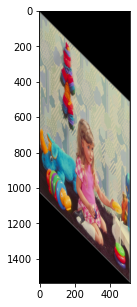

In [202]:
T = np.array([[2, 1, 0],
              [0, 1, 0],
              [0, 0, 1]])
girl_transformed = np.zeros((1536, 512, 3), dtype=np.uint8)
girl_transformed = affine_transform(girl_img, 1536, 512, T)
plt.figure(figsize=(5,5))
plt.imshow(girl_transformed)

But we need to resize the transformeed image to fit on the Cube, for this purpose we use the `resize` function from OpenCV, although we can also use the affine transforms, but this is just as well.
The interpolation used is NN to match the previous transforms.

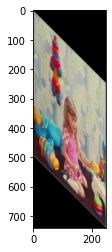

In [193]:
import cv2
girl_scaled = cv2.resize(girl_transformed, (242, 726), cv2.INTER_NEAREST)
plt.imshow(girl_scaled)

(741, 247, 3)


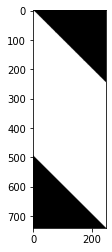

In [206]:
mask = (girl_scaled != [0,0,0]).all(-1)
plt.imshow(mask)
mask = np.dstack([mask]*3)
print(mask.shape)

To mask the image on the cube, we copy all its pixels on a copy of the background and replace the black pixels (empty areas) with the original background (Cube).

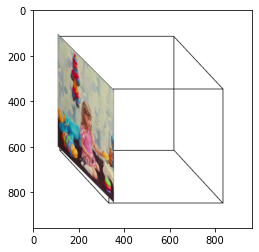

In [194]:
cubed = np.copy(cube)
# the cube elements are of type float
height, width, _ = girl_scaled.shape
x, y = 105, 108 
cubed[x:min(x+height, cubed.shape[0]), y:min(y+width, cubed.shape[1])] = girl_scaled
mask_ind = (cubed == 0)
cubed[mask_ind] = cube[mask_ind]
plt.imshow(cubed)